# Task 1: Symbolic Unconditioned Generation

# Section 1: Exploratory Analysis

## Context 
- This dataset comes from the NES-MDB Dataset, which is 5278 soundtracks of 397 NES games. It was built from the assembly code of NES games and shared in a github repository (https://github.com/chrisdonahue/nesmdb?tab=readme-ov-file#midi-format).
- We chose this dataset because the 8-bit music offers a very manageable vocabulary for potentially easier model training. Even with 'low' vocabulary, we think it can still produce musically engaging results and allow us to experiment with more sophisticated generative architectures such as Transformers.
## Discussion
- Data preprocessing: The data was already cleaned very well for our purposes. However we filtered out pieces that were less than 20 seconds. This is because the dataset also contained sound effects that we are not planning to generate. Furthermore, we decided to not use files with unreasonably high ticks in the midi (over a million)
- Training data: The data comes with training, validation and test sets. We trained on the entire dataset (after filtering) so that we can maximize the vocabulary and learning of our models.
## Code (Tables and Graphs): 

In [27]:
import os
import glob
import pandas as pd
import numpy as np
import pretty_midi
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

%matplotlib inline

In [13]:
data_path = r"data/nesmdb_midi/" 

folders_to_process = {
    "train": os.path.join(data_path, "train"),
    "test": os.path.join(data_path, "test"),
    "valid": os.path.join(data_path, "valid")
}

folders_to_process

{'train': 'data/nesmdb_midi/train',
 'test': 'data/nesmdb_midi/test',
 'valid': 'data/nesmdb_midi/valid'}

In [18]:
midi_paths = (
    glob.glob(os.path.join(folders_to_process['train'], "*.mid")) + 
    glob.glob(os.path.join(folders_to_process['test'], "*.mid")) + 
    glob.glob(os.path.join(folders_to_process['valid'], "*.mid"))
)
print(f"Found {len(midi_paths)} MIDI files.")

Found 5278 MIDI files.


# Basic Statistics of our midi files

In [34]:
records = []
num_skipped = 0
for path in tqdm(midi_paths):
    try:
        pm = pretty_midi.PrettyMIDI(path)
        duration = pm.get_end_time()

        all_notes = [note for inst in pm.instruments for note in inst.notes]
        total_notes = len(all_notes)
        if total_notes > 0:
            velocities = np.array([note.velocity for note in all_notes])
            unique_pitches = len({note.pitch for note in all_notes})
            avg_velocity = velocities.mean()
            note_density = total_notes / duration
        else:
            unique_pitches = 0
            avg_velocity = np.nan
            note_density = 0

        records.append({
            'path': path,
            'file': os.path.basename(path),
            'duration_s': duration,
            'total_notes': total_notes,
            'unique_pitches': unique_pitches,
            'avg_velocity': avg_velocity,
            'num_instruments': len(pm.instruments),
            'note_density': note_density
        })
    except ValueError as e:
        num_skipped += 1
        # print(f"Skipping file {os.path.basename(path)} due to error: {e}")
    except Exception as e:
        num_skipped += 1
        # print(f"Skipping file {os.path.basename(path)} due to an unexpected error: {e}")
print(f'Skipped {num_skipped} number of files due to unreasonable tick')


  0%|          | 0/5278 [00:00<?, ?it/s]

Skipped 30 number of files due to unreasonable tick


In [35]:
df = pd.DataFrame(records)
cleaned_paths = df['path'].tolist()
print(cleaned_paths)
df.head()
df.describe()

['data/nesmdb_midi/train/238_MikeTyson_sPunch_Out___11_12WeHaveaNewChampion.mid', 'data/nesmdb_midi/train/108_Famista_90_10_11Unknown2.mid', 'data/nesmdb_midi/train/134_GanbareGoemon2_07_08Underpass.mid', 'data/nesmdb_midi/train/178_Ironsword_Wizards_amp_WarriorsII_12_13FireElemental.mid', 'data/nesmdb_midi/train/387_Wizardry_ProvingGroundsofTheMadOverlord_16_17Werdna.mid', 'data/nesmdb_midi/train/270_Punch_Out___01_02NameEntry.mid', 'data/nesmdb_midi/train/195_KonamiWaiWaiWorld_18_19FinalStageBossBGM.mid', 'data/nesmdb_midi/train/050_ChaosWorld_20_21Chaos.mid', 'data/nesmdb_midi/train/135_GanbareGoemonGaiden2_TenkanoZaih__45_46PosanVillageMinatoVillage.mid', 'data/nesmdb_midi/train/100_Falsion_05_06FlyingHighStage5BGM.mid', 'data/nesmdb_midi/train/336_TenchioKurauII_ShokatsuKoumeiDen_18_19Cave2.mid', 'data/nesmdb_midi/train/045_Castlevania_13_14BlackNight.mid', 'data/nesmdb_midi/train/076_DonkeyKongCountry4_00_01Theme.mid', 'data/nesmdb_midi/train/070_DigDugII_09_101000000ScoreFanfare

,duration_s,total_notes,unique_pitches,avg_velocity,num_instruments,note_density
count,5248.000000,5248.000000,5248.000000,5244.000000,5248.000000,5248.000000
mean,29.148773,600.625953,30.328506,6.368597,3.369665,20.321462
std,29.663653,848.790110,14.971707,2.765557,0.782510,18.081906
min,0.086077,0.000000,0.000000,1.000000,0.000000,0.000000
25%,6.437982,90.000000,19.000000,4.378319,3.000000,9.515238
50%,21.559240,304.000000,29.000000,6.025641,4.000000,15.309039
75%,41.538588,781.250000,40.000000,8.104815,4.000000,25.607766
max,225.764853,10454.000000,92.000000,15.000000,4.000000,290.437302


In [36]:
df.nlargest(10, 'note_density')[['file', 'note_density', 'total_notes', 'duration_s']]

,file,note_density,total_notes,duration_s
4331,267_Pooyan_08_09RockFallDanger2.mid,290.437302,25,0.086077
4340,267_Pooyan_07_08RockFallDanger1.mid,283.400810,100,0.352857
328,267_Pooyan_03_04StageDemo1.mid,257.990042,1773,6.872358
1814,267_Pooyan_09_10StageDemo2.mid,256.574463,1649,6.426984
261,267_Pooyan_14_15StageDemo4Unused.mid,248.677373,1709,6.872358
2163,267_Pooyan_13_14StageDemo3Unused.mid,217.445517,1422,6.539569
2839,135_GanbareGoemonGaiden2_TenkanoZaih__88_89UFO...,207.170231,38,0.183424
3887,245_MoonCrystal_15_16Death.mid,190.804839,206,1.079637
4823,158_HikarinoSenshiPhoton_WakuseiZoldiasnoTatak...,159.281723,106,0.665488
837,044_CastleofDragon_14_15GameOver.mid,151.377150,292,1.928957


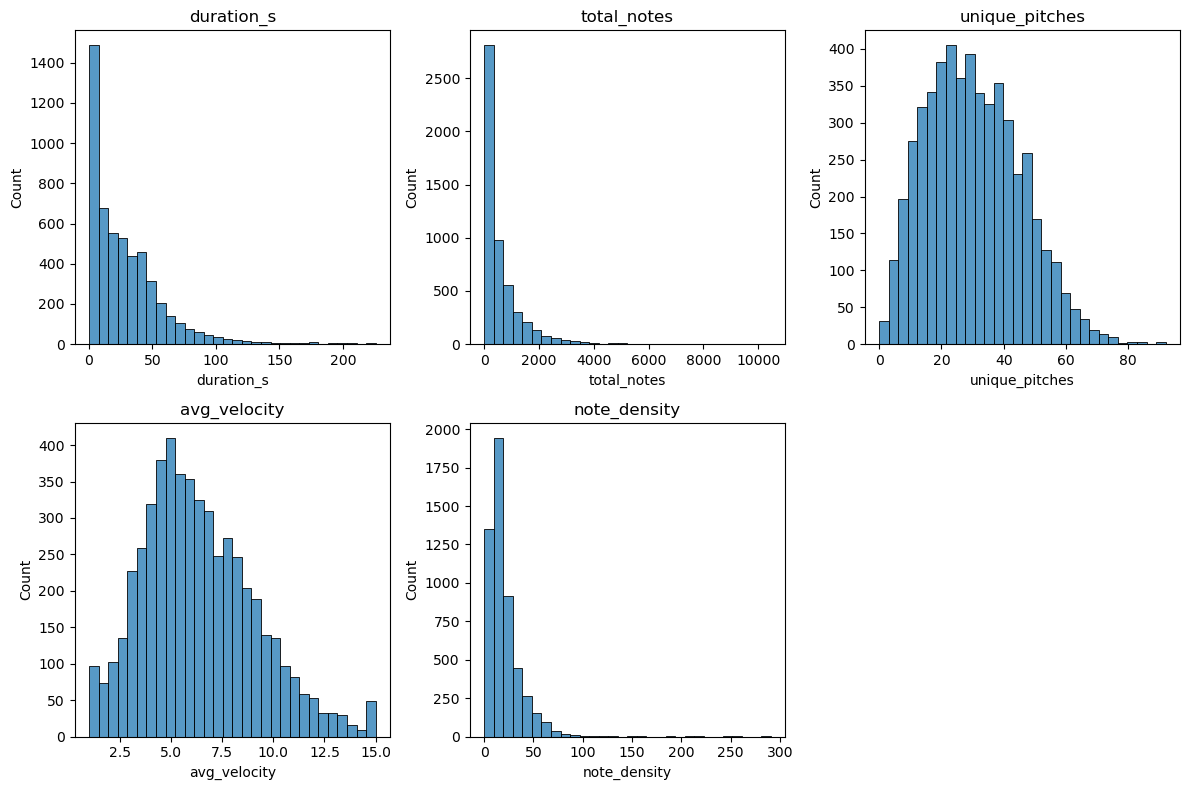

In [37]:
metrics = ['duration_s', 'total_notes', 'unique_pitches', 'avg_velocity', 'note_density']
plt.figure(figsize=(12, 8))
for i, m in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[m].dropna(), bins=30, kde=False)
    plt.title(m)
plt.tight_layout()
plt.show()

## Statistics to note:
- Most pieces are around the 0-50 seconds range.
- The mean for notes is around 600 notes per piece.
- There is a relatively large distribution for unique pitches across the songs with a mean of 30 and a 
- Most velocities are around 10 to 50, with a mean of 30.
- The note density is quite varied between 0-250 but a majority are in the 0-25 range. 

# More Specific Data

In [38]:
ext_records = []
for path in tqdm(cleaned_paths):
    pm = pretty_midi.PrettyMIDI(path)
    # Polyphony: sample time grid for active note counts
    times = np.linspace(0, pm.get_end_time(), num=500)
    active_counts = [sum(1 for inst in pm.instruments for note in inst.notes if note.start <= t < note.end) for t in times]
    max_poly = int(max(active_counts))
    avg_poly = float(np.mean(active_counts))

    # Tempo
    tempo_changes, tempi = pm.get_tempo_changes()
    mean_tempo = float(np.mean(tempi)) if len(tempi)>0 else np.nan
    tempo_range = float(np.max(tempi)-np.min(tempi)) if len(tempi)>1 else 0.0

    # Key and time signature events
    key_sigs = [ks.key_number for ks in pm.key_signature_changes]
    time_sigs = [(ts.numerator, ts.denominator) for ts in pm.time_signature_changes]
    key_mode = key_sigs[0] if key_sigs else None
    time_sig = time_sigs[0] if time_sigs else (None, None)

    # Note durations and IOIs
    note_durs = np.array([note.end-note.start for inst in pm.instruments for note in inst.notes])
    ioi = np.diff([note.start for inst in pm.instruments for note in inst.notes])
    dur_q = np.quantile(note_durs, [0.25, 0.5, 0.75]) if note_durs.size>0 else [np.nan]*3
    ioi_mean = float(np.mean(ioi)) if ioi.size>0 else np.nan
    ioi_var = float(np.var(ioi)) if ioi.size>0 else np.nan

    # Pitch-class histogram
    pitches = [note.pitch % 12 for inst in pm.instruments for note in inst.notes]
    pc_hist = np.bincount(pitches, minlength=12)
    pc_hist_norm = pc_hist / pc_hist.sum() if pc_hist.sum()>0 else pc_hist

    ext_records.append({
        'file': os.path.basename(path),
        'max_polyphony': max_poly,
        'avg_polyphony': avg_poly,
        'mean_tempo_bpm': mean_tempo,
        'tempo_range_bpm': tempo_range,
        'key_signature': key_mode,
        'time_signature': f"{time_sig[0]}/{time_sig[1]}",
        'dur_q1': dur_q[0], 'dur_q2': dur_q[1], 'dur_q3': dur_q[2],
        'ioi_mean': ioi_mean, 'ioi_var': ioi_var,
        **{f'pc_{i}': pc_hist_norm[i] for i in range(12)}
    })

  0%|          | 0/5248 [00:00<?, ?it/s]

,file,max_polyphony,avg_polyphony,mean_tempo_bpm,tempo_range_bpm,key_signature,time_signature,dur_q1,dur_q2,dur_q3,...,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10,pc_11
count,5248,5248.000000,5248.000000,5248.0,5248.0,0,5248,5244.000000,5244.000000,5244.000000,...,5248.000000,5248.000000,5248.000000,5248.000000,5248.000000,5248.000000,5248.000000,5248.000000,5248.000000,5248.000000
unique,5248,NaN,NaN,NaN,NaN,0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,238_MikeTyson_sPunch_Out___11_12WeHaveaNewCham...,NaN,NaN,NaN,NaN,NaN,4/4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,5248,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,3.346418,2.348606,120.0,0.0,NaN,NaN,0.079176,0.126561,0.210748,...,0.114211,0.084475,0.101403,0.072650,0.052667,0.094534,0.051084,0.109775,0.068886,0.072348
std,NaN,0.792596,0.691957,0.0,0.0,NaN,NaN,0.131580,0.164838,0.249025,...,0.090959,0.095585,0.091455,0.070201,0.064058,0.077782,0.063634,0.092802,0.069849,0.071779
min,NaN,0.000000,0.000000,120.0,0.0,NaN,NaN,0.000023,0.000023,0.003696,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,3.000000,1.912000,120.0,0.0,NaN,NaN,0.016553,0.057647,0.099841,...,0.048099,0.008607,0.034188,0.019258,0.002637,0.038289,0.001175,0.044888,0.014706,0.018868
50%,NaN,4.000000,2.456000,120.0,0.0,NaN,NaN,0.062494,0.099796,0.149751,...,0.098354,0.054089,0.082569,0.060000,0.032368,0.082321,0.031320,0.091805,0.053435,0.055941
75%,NaN,4.000000,2.874000,120.0,0.0,NaN,NaN,0.099819,0.149751,0.232948,...,0.159270,0.125924,0.143178,0.103106,0.077169,0.130565,0.076608,0.151877,0.101287,0.103786


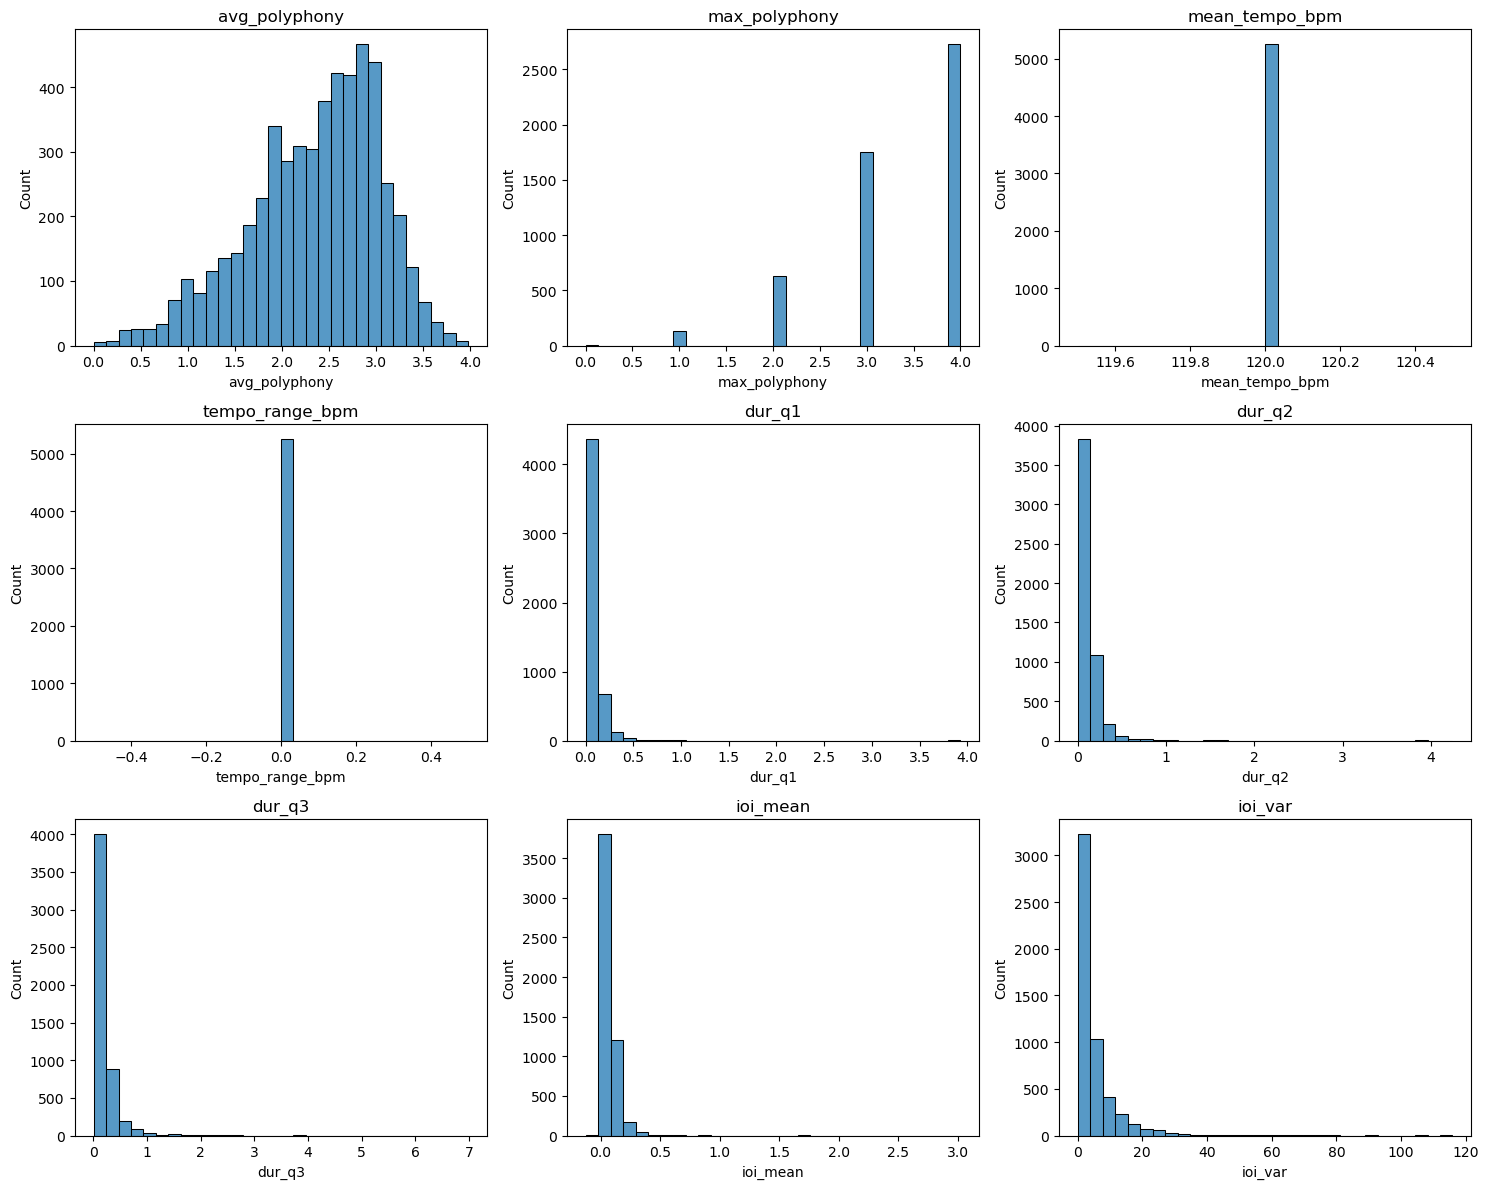

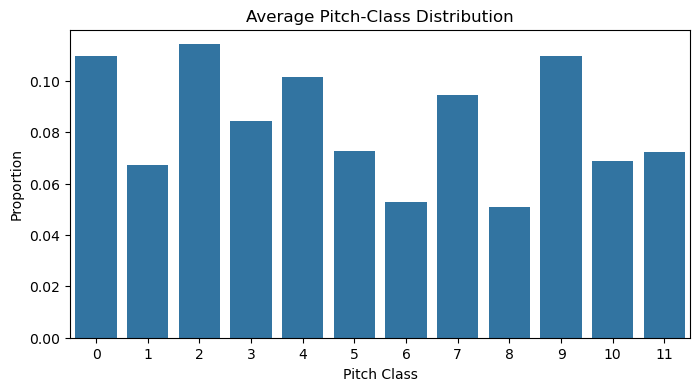

In [41]:
df_ext = pd.DataFrame(ext_records)
display(df_ext.describe(include='all'))

# Histogram plots for extended metrics
ext_metrics = [
    'avg_polyphony', 'max_polyphony',
    'mean_tempo_bpm', 'tempo_range_bpm',
    'dur_q1', 'dur_q2', 'dur_q3',
    'ioi_mean', 'ioi_var'
]
plt.figure(figsize=(15, 12))
for i, m in enumerate(ext_metrics, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df_ext[m].dropna(), bins=30)
    plt.title(m)
plt.tight_layout()
plt.show()

# Average pitch-class distribution
pc_cols = [f'pc_{i}' for i in range(12)]
pc_mean = df_ext[pc_cols].mean()
plt.figure(figsize=(8, 4))
sns.barplot(x=list(range(12)), y=pc_mean.values)
plt.title('Average Pitch-Class Distribution')
plt.xlabel('Pitch Class')
plt.ylabel('Proportion')
plt.show()